In [3]:
!pip -q install monai gdown einops mlflow pynrrd torchinfo 
!pip install pandas numpy nibabel tqdm
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.0.1 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
python-language-server 0.31.7 requires jedi<0.16,>=0.14.1, but you have jedi 0.18.2 which is incompatible.
python-language-server 0.31.7 requires ujson<=1.35; platform_system != "Windows", but you have ujson 5.7.0 which is incompatible.
sagemaker 2.165.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 5.2.0 which is incompatible.
sagemaker-data-insights 0.3.3 requires numpy>=1.21.6, but you have numpy 1.21.5 which is incompatible.
sagemaker-datawrangler 0.4.3 requires s

In [2]:
import os
from glob import glob
import shutil
import tempfile
import time
import warnings
import torch
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from collections.abc import Callable, Sequence, Hashable
from typing import Mapping,Dict
import matplotlib.pyplot as plt

from monai.transforms import (
    EnsureType,
    FillHoles,
    OneOf,
    SpatialCropd,
    Activations,
    Activationsd,
    ConcatItemsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    RandAffined,
    NormalizeIntensityd,
    ToTensord,
    EnsureChannelFirstd ,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    NormalizeIntensityd,
    Resized,
    SaveImaged,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandSpatialCropSamplesd,
    RandFlipd,
    RandRotated,
    EnsureTyped,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
)

from monai.handlers.utils import from_engine
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import SegResNet
from monai.data import Dataset, DataLoader, CacheDataset, decollate_batch
from monai.utils import first
from monai.utils import set_determinism
from monai.config import print_config
from monai.data.meta_tensor import MetaTensor
from monai.config.type_definitions import NdarrayOrTensor
from monai.utils.misc import ImageMetaKey

In [3]:
set_determinism(seed=123)

In [18]:
root_dir = 'model_data'
data_dir = 'data'

train_images_ct = sorted(glob(os.path.join(data_dir, 'TrainData', '*_CT.nii.gz')))
train_images_pt = sorted(glob(os.path.join(data_dir, 'TrainData', '*_PT.nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'TrainLabels', '*.nii.gz')))
train_files = [{"image": image_name, "image2": pet_image, 'label': label_name} for image_name, pet_image, label_name in zip(train_images_ct, train_images_pt, train_labels)]

val_images_ct = sorted(glob(os.path.join(data_dir, 'ValData', '*_CT.nii.gz')))
val_images_pt = sorted(glob(os.path.join(data_dir, 'ValData', '*_PT.nii.gz')))
val_labels = sorted(glob(os.path.join(data_dir, 'ValLabels', '*.nii.gz')))
val_files = [{"image": image_name, "image2": pet_image, 'label': label_name} for image_name, pet_image, label_name in zip(val_images_ct, val_images_pt, val_labels)]

In [5]:
print(train_files)
print(val_files)
# print(test_files)

[{'image': 'data/TrainData/CHUM-001__CT.nii.gz', 'image2': 'data/TrainData/CHUM-001__PT.nii.gz', 'label': 'data/TrainLabels/CHUM-001.nii.gz'}, {'image': 'data/TrainData/CHUM-002__CT.nii.gz', 'image2': 'data/TrainData/CHUM-002__PT.nii.gz', 'label': 'data/TrainLabels/CHUM-002.nii.gz'}, {'image': 'data/TrainData/CHUM-006__CT.nii.gz', 'image2': 'data/TrainData/CHUM-006__PT.nii.gz', 'label': 'data/TrainLabels/CHUM-006.nii.gz'}, {'image': 'data/TrainData/CHUM-007__CT.nii.gz', 'image2': 'data/TrainData/CHUM-007__PT.nii.gz', 'label': 'data/TrainLabels/CHUM-007.nii.gz'}, {'image': 'data/TrainData/CHUM-008__CT.nii.gz', 'image2': 'data/TrainData/CHUM-008__PT.nii.gz', 'label': 'data/TrainLabels/CHUM-008.nii.gz'}, {'image': 'data/TrainData/CHUM-013__CT.nii.gz', 'image2': 'data/TrainData/CHUM-013__PT.nii.gz', 'label': 'data/TrainLabels/CHUM-013.nii.gz'}, {'image': 'data/TrainData/CHUM-014__CT.nii.gz', 'image2': 'data/TrainData/CHUM-014__PT.nii.gz', 'label': 'data/TrainLabels/CHUM-014-Copy1.nii.gz'}]

In [6]:
va_files = []
# va_files.append(val_files[0])
va_files.append(train_files[2])
va_files

[{'image': 'data/TrainData/CHUM-006__CT.nii.gz',
  'image2': 'data/TrainData/CHUM-006__PT.nii.gz',
  'label': 'data/TrainLabels/CHUM-006.nii.gz'}]

In [7]:
tfiles = []
tfiles.append(train_files[2])
tfiles.append(train_files[1])
tfiles

[{'image': 'data/TrainData/CHUM-006__CT.nii.gz',
  'image2': 'data/TrainData/CHUM-006__PT.nii.gz',
  'label': 'data/TrainLabels/CHUM-006.nii.gz'},
 {'image': 'data/TrainData/CHUM-002__CT.nii.gz',
  'image2': 'data/TrainData/CHUM-002__PT.nii.gz',
  'label': 'data/TrainLabels/CHUM-002.nii.gz'}]

In [8]:
class HecktorCropNeckRegion(CropForegroundd):
    """
    A simple pre-processing transform to approximately crop the head and neck region based on a PET image.
    This transform relies on several assumptions of patient orientation with a head location on the top,
    and is specific for Hecktor22 dataset, and should not be used for an arbitrary PET image pre-processing.
    """

    def __init__(
        self,
        keys=["image", "image2", "label"],
        source_key="image",
        box_size=[200, 200, 310],
        allow_missing_keys=True,
        **kwargs,
    ) -> None:
        super().__init__(keys=keys, source_key=source_key, allow_missing_keys=allow_missing_keys, **kwargs)
        self.box_size = box_size

    def __call__(self, data : Mapping[Hashable, torch.Tensor]) -> Dict[Hashable, torch.Tensor]:

        d = dict(data)
        im_pet = d["image2"][0]
        #print(im_pet)
        box_size = np.array(self.box_size)  # H&N region to crop in mm , defaults to 200x200x310mm
        filename = ""

        if isinstance(im_pet, MetaTensor):
            filename = im_pet.meta[ImageMetaKey.FILENAME_OR_OBJ]
            box_size = (box_size / np.array(im_pet.pixdim)).astype(int)  # compensate for resolution

        box_start, box_end = self.extract_roi(im_pet=im_pet, box_size=box_size)
        
        if "label" in d and "label" in self.keys:
            # if label mask is available, let's check if the cropped region includes all foreground
            before_sum = d["label"].sum().item()
            after_sum = (
                (d["label"][0, box_start[0] : box_end[0], box_start[1] : box_end[1], box_start[2] : box_end[2]])
                .sum()
                .item()
            )
            if before_sum != after_sum:
                print("WARNING, H&N crop could be incorrect!!!", before_sum, after_sum)

        d[self.start_coord_key] = box_start
        d[self.end_coord_key] = box_end
        
        for key, m in self.key_iterator(d, self.mode): #question: what is mode in the iterators?
            self.push_transform(d, key, extra_info={"box_start": box_start, "box_end": box_end})
            d[key] = self.cropper.crop_pad(img=d[key], box_start=box_start, box_end=box_end, mode=m)
        return d

    def extract_roi(self, im_pet, box_size):

        crop_len = int(0.75 * im_pet.shape[2])
        im = im_pet[..., crop_len:]

        mask = ((im - im.mean()) / im.std()) > 1
        comp_idx = torch.argwhere(mask)
        center = torch.mean(comp_idx.float(), dim=0).cpu().int().numpy()
        xmin = torch.min(comp_idx, dim=0).values.cpu().int().numpy()
        xmax = torch.max(comp_idx, dim=0).values.cpu().int().numpy()

        xmin[:2] = center[:2] - box_size[:2] // 2
        xmax[:2] = center[:2] + box_size[:2] // 2

        xmax[2] = xmax[2] + crop_len
        xmin[2] = max(0, xmax[2] - box_size[2])

        return xmin.astype(int), xmax.astype(int)

In [9]:
 class CalculateCentreOfMass(CropForegroundd):
        def __init__(self, keys=["image", "image2", "label"], source_key="image", **kwargs):
            super().__init__(keys=keys, source_key=source_key, **kwargs)
        def __call__(self, data : Mapping[Hashable, torch.Tensor]):
            d = dict(data)
            #img_pet = d["image2"][0]
            #img_nib = img_pet #nib.load("C:/Users/Julia Scott/Documents/Varian_2022/Hecktor2022/Hecktor_test/data\\TrainData\\CHUM-007__PT.nii.gz")
            #image = img_nib
            def CalculateCenterOfMass():
                image_tensor = d["image2"][0]
                meshgrid = torch.meshgrid([torch.arange(image_size) for image_size in image_tensor.shape])
                center_of_mass = torch.stack([torch.sum(image_tensor * meshgrid[dim]) / torch.sum(image_tensor) for dim in range(3)])
                return center_of_mass.tolist()
            SpatialCropd(keys=["image", "image2", "label"],roi_center = CalculateCenterOfMass(), roi_size=[192, 192, 192])
            return d

In [23]:
class ConvertToMultiChannelBasedOnClassesd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] == 1)
            result.append(d[key] == 2)
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [34]:
# device = torch.device("cuda:0")
train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'image2', 'label']),
        EnsureChannelFirstd(keys = ['image', 'image2']),
        EnsureTyped(keys=["image", 'image2', "label"]),
        Spacingd(
            keys=["image", 'image2'],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ConvertToMultiChannelBasedOnClassesd(keys='label'),
        HecktorCropNeckRegion(keys=["image", 'image2', "label"], source_key="image"),
        # CalculateCentreOfMass(keys=["image", "image2", "label"], source_key="image"),
        Orientationd(keys=["image", "image2"], axcodes="RAS"),
        # RandSpatialCropd(keys=["image", 'image2', "label"], roi_size=[192, 192, 192], random_size=False),
        ScaleIntensityd(keys=["image", "image2"], minv=0.0, maxv=1.0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        NormalizeIntensityd(keys="image2", nonzero=True, channel_wise=True),
        RandFlipd(keys=["image", "image2", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "image2", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "image2", "label"], prob=0.5, spatial_axis=2),
        ConcatItemsd(keys=["image", "image2"], name="image_petct", dim=0),
        # RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        # RandRotated(keys=["image", "image2", "label"], prob = 0.5),
        
        
        # SaveImaged(
        # keys = ['image', 'image2', 'label'],
        # output_dir='data/output',
        # output_postfix="crop",
        # resample=False,
        # output_dtype=np.int16,
        # separate_folder=False,
        # )
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=['image', 'image2', 'label']),
        EnsureChannelFirstd(keys = ['image', 'image2', 'label']),
        EnsureTyped(keys=["image", 'image2', "label"]),
        Spacingd(
            keys=["image", 'image2'],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        HecktorCropNeckRegion(keys=["image", 'image2', "label"], source_key="image"),
        # CalculateCentreOfMass(keys=["image", "image2", "label"], source_key="image"),
        # ConvertToMultiChannelBasedOnClassesd(keys='label'),
        Orientationd(keys=["image", "image2"], axcodes="RAS"),
        
        # RandSpatialCropd(keys=["image", 'image2', "label"], roi_size=[192, 192, 192], random_size=False),
        ScaleIntensityd(keys=["image", "image2"], minv=0.0, maxv=1.0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        NormalizeIntensityd(keys="image2", nonzero=True, channel_wise=True),
        ConcatItemsd(keys=["image", "image2"], name="image_petct", dim=0),
        
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-57, a_max=164,
        #     b_min=0.0, b_max=1.0, clip=True,
        # ),
    ]
)

original_transforms = Compose(
    [
         LoadImaged(keys=['image', 'image2', 'label']),
         EnsureChannelFirstd(['image', 'image2', 'label']),

    ]
)

In [35]:
check_ds = Dataset(data=tfiles, transform=train_transforms)
# check_data = check_ds[0]
check_loader = DataLoader(check_ds, batch_size=1)
for check_data in check_loader:
    print(check_data['image_petct'].shape)
    # print(check_data['image2'].shape)
    print(check_data['label'].shape)
    break
image, label = (check_data["image_petct"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

WARNING, H&N crop could be incorrect!!! 10121.0 2720.0
torch.Size([1, 2, 200, 200, 310])
torch.Size([1, 3, 200, 200, 310])
image shape: torch.Size([200, 200, 310]), label shape: torch.Size([200, 200, 310])


image shape: torch.Size([200, 200, 310]), label shape: torch.Size([200, 200, 310])


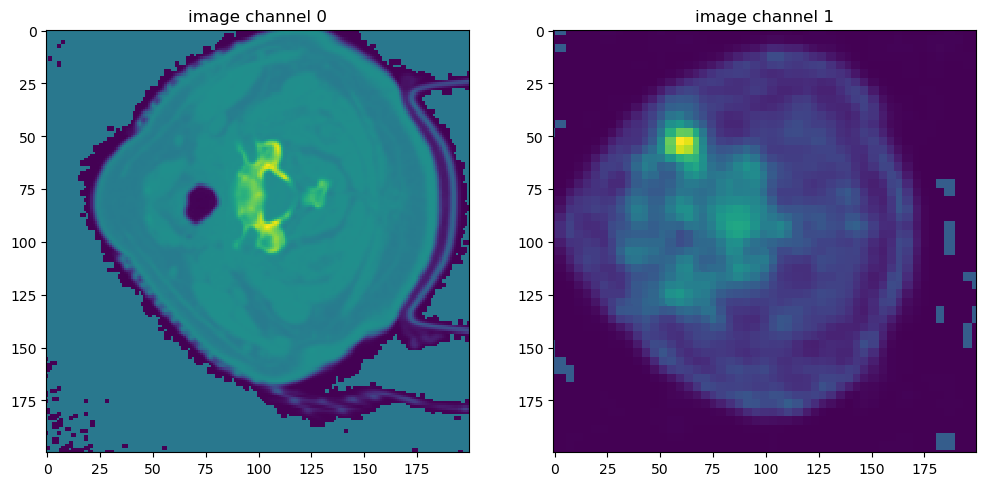

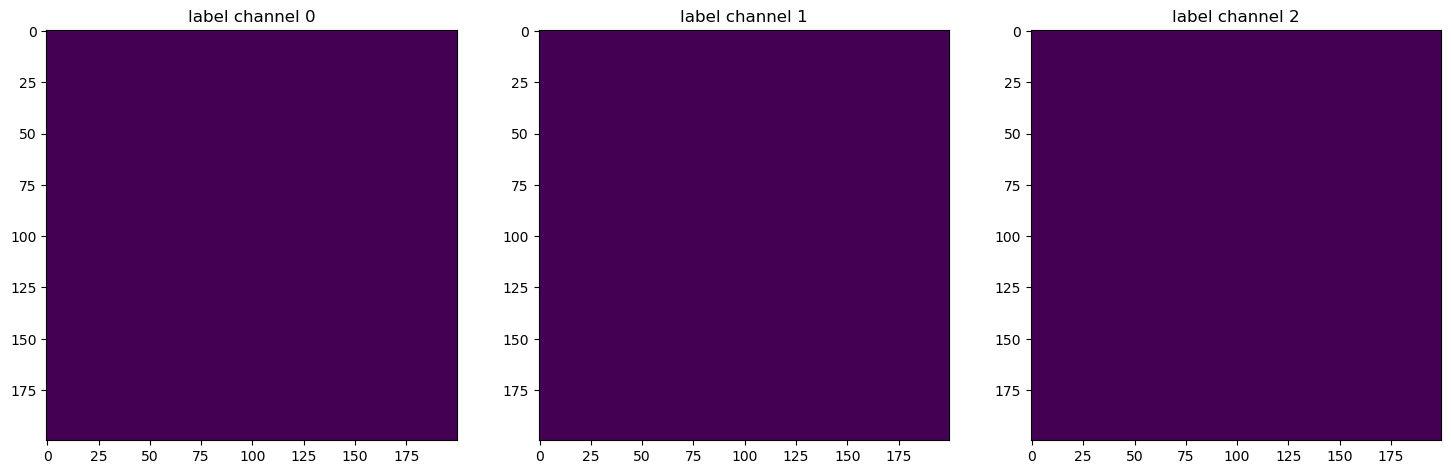

In [36]:
# check_data = check_ds[1]
# image, label = (check_data["image_petct"][0], check_data["label"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("image_petct", (12, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(check_data["image_petct"][0][i, :, :, 150].detach().cpu())
plt.show()
# plt.figure("image2", (12, 6))
# for i in range(1):
#     plt.subplot(1, 2, i + 1)
#     plt.title(f"label channel {i}")
#     plt.imshow(check_data["image2"][0][i, :, :, 150].detach().cpu())
# plt.show()
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(check_data["label"][0][i, :, :, 150].detach().cpu())
plt.show()

In [37]:
train_ds = CacheDataset(data=tfiles, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/monai/data/dataset.py:867: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


WARNING, H&N crop could be incorrect!!! 3992.0 3606.0
WARNING, H&N crop could be incorrect!!! 10121.0 2720.0


In [ ]:
orig_ds = Dataset(data=tfiles, transform=original_transforms)
print(orig_ds[0]['image'].shape)
print(orig_ds[0]['image2'].shape)
print(orig_ds[0]['label'].shape)

In [14]:
# print(train_ds[0]['image'].shape)
# print(train_ds[0]['image2'].shape)
# print(train_ds[0]['label'].shape)
# print(train_ds[1]['image'].shape)
# print(train_ds[1]['image2'].shape)
# print(train_ds[1]['label'].shape)
for data in train_loader:
    print(data['image'].shape)
    print(data['label'].shape)

torch.Size([1, 1, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])


In [ ]:
val_ds = CacheDataset(data=tfiles, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

In [13]:
# print(val_ds[0]['image'].shape)
# print(val_ds[0]['image2'].shape)
# print(val_ds[0]['label'].shape)
# image = first(val_loader)
# image['image'].shape
# val_ds[0]['image'].meta[ImageMetaKey.FILENAME_OR_OBJ]
for data in val_loader:
    print(data['image_petct'].shape)
    print(data['label'].shape)

torch.Size([1, 2, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])
torch.Size([1, 2, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])


In [14]:
max_epochs = 2
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=2,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
# dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(192, 192, 192),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [ ]:
torch.cuda.empty_cache()

In [17]:
!nvidia-smi

Wed Jun 21 17:42:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P0    25W /  70W |  11994MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image_petct"].to(device),
            batch_data["label"].to(device),
        )
        print(inputs.shape)
        print(labels.shape)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image_petct"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                # dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            # metric_batch = dice_metric_batch.aggregate()
            # metric_tc = metric_batch[0].item()
            # metric_values_tc.append(metric_tc)
            # metric_wt = metric_batch[1].item()
            # metric_values_wt.append(metric_wt)
            # metric_et = metric_batch[2].item()
            # metric_values_et.append(metric_et)
            dice_metric.reset()
            # dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                # f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/2
torch.Size([1, 2, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])
1/2, train_loss: 0.9974, step time: 0.9961
torch.Size([1, 2, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])
2/2, train_loss: 0.9862, step time: 0.9143
epoch 1 average loss: 0.9918
saved new best metric model
current epoch: 1 current mean dice: 0.0204
best mean dice: 0.0204 at epoch: 1
time consuming of epoch 1 is: 7.7655
----------
epoch 2/2
torch.Size([1, 2, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])
1/2, train_loss: 1.0000, step time: 0.9741
torch.Size([1, 2, 192, 192, 192])
torch.Size([1, 1, 192, 192, 192])
2/2, train_loss: 0.9849, step time: 0.9192
epoch 2 average loss: 0.9924
current epoch: 2 current mean dice: 0.0202
best mean dice: 0.0204 at epoch: 1
time consuming of epoch 2 is: 7.6436


In [20]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.0204 at epoch: 1, total time: 15.409924030303955.


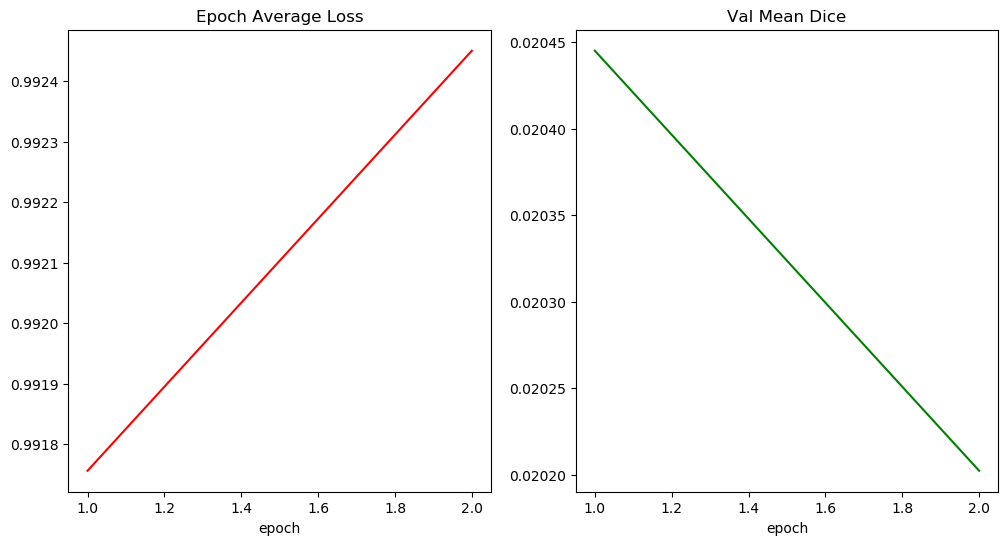

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

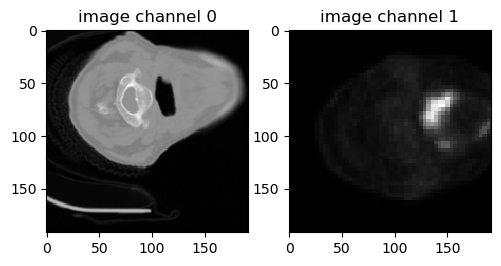

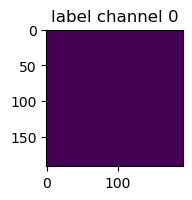

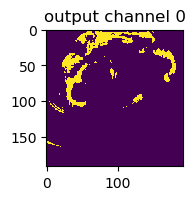

In [22]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[1]["image_petct"].unsqueeze(0).to(device)
    roi_size = (192, 192, 192)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (12, 6))
    for i in range(2):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[1]["image_petct"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (6, 6))
    for i in range(1):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[1]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (6, 6))
    for i in range(1):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()